<a href="https://colab.research.google.com/github/leticiasdrummond/Modelos-Base/blob/main/1_3_Otimiza%C3%A7%C3%A3o_de_Rede_com_Limite_Contratado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso Adaptado - Nova Função Objetivo
Gerado no GEMINI com comando que dispunha das orientações do ChatGPT sobre manutenções e alterações do Caso Base ao propor outra Funçãpo Objetivo.

Resultado ao exportar ao Colab:
Aqui está o código completo e comentado, pronto para ser executado no Google Colab. Este código incorpora as modificações solicitadas: a nova função objetivo para minimizar a dependência da rede e a restrição de demanda máxima de 75 kW.

Alterações Manuais:
* Como foi gerado
* Aumento da demanda máxima restringida para 130 kW e não mais 75 kW
* Simulado com 75 kW o solver não encontrou uma solução ótima.
  * Verifiquei que a demanda excede 75kW + BESS + PV.
*Simulado com 130 kW para PGrid Máx
  * Novo valor proposto corresponde a 100kW do Carregamento EV + 30kW médios do comércio
  * Total de energia comprada da rede: 849 kWh


* [Colab/GitHub base](https://github.com/leticiasdrummond/Modelos-Base/blob/main/1_2_1_caso_referencia_min_custo_energ.ipynb)
* [Modificação recomendada GPT](https://chatgpt.com/share/699cde91-4b8c-8013-a44f-2273671a60ed)

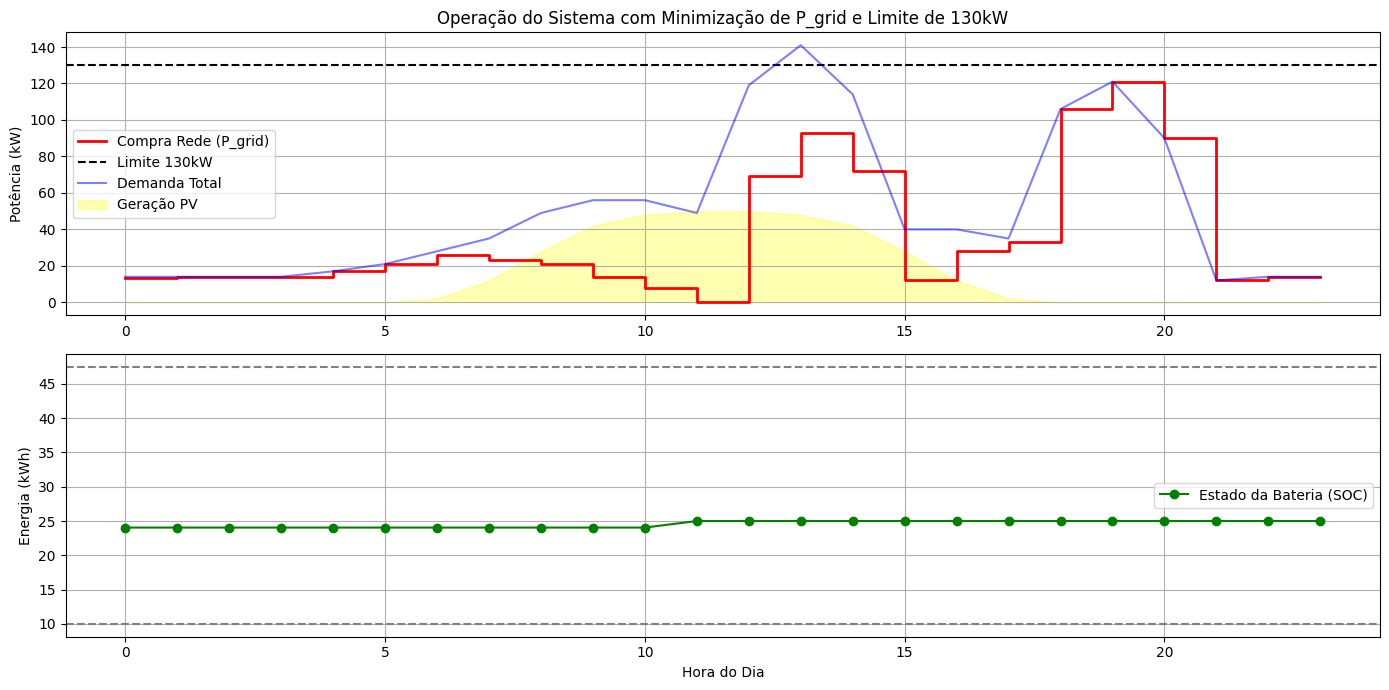

Total de energia comprada da rede: 8.49e+02 kWh


In [3]:
# ============================================================
# 1. INSTALAÇÃO E IMPORTAÇÃO (Configuração Colab)
# ============================================================
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2. DADOS DE ENTRADA (Baseados no Caso de Referência)
# ============================================================
T = range(24) # Horizonte de 24 horas

# Demandas (kW) -
demanda_comercio = [
    14, 14, 14, 14, 17, 21, 28, 35, 49, 56, 56, 49,
    47, 45, 42, 40, 40, 35, 30, 21, 14, 12, 14, 14
]
demanda_ev = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    72, 96, 72, 0, 0, 0, 76, 100, 76, 0, 0, 0
]

# Geração Fotovoltaica (kW) -
geracao_pv = [
    0, 0, 0, 0, 0, 0, 2, 12, 28, 42, 48, 50,
    50, 48, 42, 28, 12, 2, 0, 0, 0, 0, 0, 0
]

# Parâmetros do BESS (Bateria) -
capacidade_bess = 50.0   # kWh
potencia_max_bess = 15.0 # kW
soc_min = 0.20 * capacidade_bess
soc_max = 0.95 * capacidade_bess
soc_inicial = 0.50 * capacidade_bess
eta_c = 0.955            # eficiência de carga
eta_d = 0.955            # eficiência de descarga

# ============================================================
# 3. CRIAÇÃO DO MODELO (MILP)
# ============================================================
model = pyo.ConcreteModel()

# --- Variáveis de Decisão ---
model.P_grid = pyo.Var(T, domain=pyo.NonNegativeReals)      # Potência comprada da rede
model.P_export = pyo.Var(T, domain=pyo.NonNegativeReals)    # Potência exportada
model.P_charge = pyo.Var(T, domain=pyo.NonNegativeReals)    # Carga do BESS
model.P_discharge = pyo.Var(T, domain=pyo.NonNegativeReals) # Descarga do BESS
model.SOC = pyo.Var(T, domain=pyo.NonNegativeReals)         # Estado de carga (kWh)

# Variáveis binárias para evitar carga/descarga simultânea
model.u_charge = pyo.Var(T, domain=pyo.Binary)
model.u_discharge = pyo.Var(T, domain=pyo.Binary)

# ============================================================
# 4. MODIFICAÇÕES PROPOSTAS
# ============================================================

# --- 4.1 Nova Função Objetivo ---
# Objetivo: Minimização da dependência da rede (Soma de P_grid)
def obj_rule(model):
    return sum(model.P_grid[t] for t in T)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# --- 4.2 Restrição de Demanda Máxima Contratada ---
# Limite de 75 kW imposto à conexão com a rede
def grid_limit_rule(model, t):
    return model.P_grid[t] <= 130.0
model.grid_limit = pyo.Constraint(T, rule=grid_limit_rule)

# ============================================================
# 5. RESTRIÇÕES QUE PERMANECEM IGUAIS
# ============================================================

# --- Balanço de Energia ---
def energy_balance_rule(model, t):
    # Geração + Importação + Descarga = Demanda + Exportação + Carga
    return (model.P_grid[t] + geracao_pv[t] + model.P_discharge[t] ==
            demanda_comercio[t] + demanda_ev[t] + model.P_charge[t] + model.P_export[t])
model.energy_balance = pyo.Constraint(T, rule=energy_balance_rule)

# --- Dinâmica do SOC ---
def soc_rule(model, t):
    if t == 0:
        return model.SOC[t] == soc_inicial + (model.P_charge[t] * eta_c) - (model.P_discharge[t] / eta_d)
    else:
        return model.SOC[t] == model.SOC[t-1] + (model.P_charge[t] * eta_c) - (model.P_discharge[t] / eta_d)
model.soc_dynamics = pyo.Constraint(T, rule=soc_rule)

# --- Limites do BESS ---
def bess_limits_rule(model, t):
    # Potência máxima e exclusividade operacional (binária)
    yield model.P_charge[t] <= potencia_max_bess * model.u_charge[t]
    yield model.P_discharge[t] <= potencia_max_bess * model.u_discharge[t]
    yield model.u_charge[t] + model.u_discharge[t] <= 1
    # Limites de energia (SOC)
    yield model.SOC[t] >= soc_min
    yield model.SOC[t] <= soc_max
model.bess_constraints = pyo.ConstraintList()
for t in T:
    for constraint in bess_limits_rule(model, t):
        model.bess_constraints.add(constraint)

# --- Condição Terminal do SOC ---
# Garante que a bateria termine o dia com pelo menos o nível inicial
model.terminal_soc = pyo.Constraint(expr= model.SOC[23] >= soc_inicial)

# ============================================================
# 6. RESOLUÇÃO DO MODELO
# ============================================================
solver = pyo.SolverFactory('cbc')
results = solver.solve(model)

# ============================================================
# 7. VISUALIZAÇÃO DOS RESULTADOS
# ============================================================
if results.solver.status == pyo.SolverStatus.ok:
    # Extração de dados para plotagem
    res_grid = [pyo.value(model.P_grid[t]) for t in T]
    res_pv = [geracao_pv[t] for t in T]
    res_soc = [pyo.value(model.SOC[t]) for t in T]
    res_demanda = [demanda_comercio[t] + demanda_ev[t] for t in T]
    res_bess = [pyo.value(model.P_discharge[t]) - pyo.value(model.P_charge[t]) for t in T]

    # Plotagem
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.step(T, res_grid, where='post', label="Compra Rede (P_grid)", color='red', linewidth=2)
    plt.axhline(y=130, color='black', linestyle='--', label="Limite 130kW")
    plt.plot(T, res_demanda, label="Demanda Total", alpha=0.5, color='blue')
    plt.fill_between(T, res_pv, color='yellow', alpha=0.3, label="Geração PV")
    plt.title("Operação do Sistema com Minimização de P_grid e Limite de 130kW")
    plt.ylabel("Potência (kW)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(T, res_soc, label="Estado da Bateria (SOC)", color='green', marker='o')
    plt.axhline(y=soc_max, color='gray', linestyle='--')
    plt.axhline(y=soc_min, color='gray', linestyle='--')
    plt.ylabel("Energia (kWh)")
    plt.xlabel("Hora do Dia")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Total de energia comprada da rede: {sum(res_grid):.2e} kWh")
else:
    print("O solver não encontrou uma solução ótima. Verifique se a demanda excede 130kW + BESS + PV.")

### Principais Alterações Implementadas:

1. **Objetivo Energético**: A função objetivo foi simplificada para `sum(model.P_grid[t] for t in T)`, removendo os custos monetários e focando exclusivamente na redução do volume de energia importada.
2. **Restrição de Capacidade**: Foi adicionada a restrição `model.P_grid[t] <= 75.0`. No gráfico resultante, você notará que a curva de compra da rede (vermelha) nunca ultrapassa a linha tracejada de 75 kW.
3. **Comportamento do BESS**: Com o novo objetivo, o BESS tenderá a ser utilizado de forma mais agressiva para cobrir picos de demanda que excedam os 75 kW contratados, especialmente nos horários de pico do eletroposto.